<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Resolviendo el problema Cart Pole con Deep $Q$-learning<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-04-19</small></i></div>
                                                  

***

## Introducción

La implementación más sencilla del $Q$-Learning utiliza una tabla para guardar todos los valores, pero esto se convierte rápidamente en inviable para entornos con muchos estados o acciones posibles. Un entorno con un espacio de observaciones continuo (prácticamente cualquiera) es uno de esos ejemplos, ya que discrretizar el espacio de acciones dispara el espacio requerido para la tabla en memoria.

Utilizando un modelo de red neuronal (profunda) para representar la función $Q(s, a)$, el agente puede generalizar mejor combinaciones no experimentadas de $(s, a)$. La entrada a este modelo sería una observación, mientras que la salida sería un valor $Q$ para cada acción permitida en ese estado. Esta implementación se denomina Deep $Q$-Learning.

## Objetivos

Vamos a tratar de resolver el problema del péndulo invertido que se implementan en el entorno [Cart Pole de Gymnasium](https://www.gymlibrary.dev/environments/classic_control/cart_pole/). Aplicaremos la técnica de _Deep $Q$-learning_, la cual es la indicada en el caso de procesos en los que el espacio de estados en el que trabajar es continuo.

![](https://blazaid.github.io/Aprendizaje-profundo/Notebooks//cart-pole.gif)

El espacio de estados se representa con un vector de 4 dimensiones donde las posiciones representan lo siguiente:
0. Posición del carrito (de -4.8 a 4.8)
1. Velocidad del carrito (de $-\infty$ a $\infty$)
2. Ángulo del péndulo (de -0.418 a 0.418)
3. Velocidad angular del péndulo (de $-\infty$ a $\infty$)

El espacio de acciones es un vector de dos dimensiones donde cada posición representa:

0. Empujar al carrito a la izquierda
1. Empujar el carrito a la derecha

## Imports y configuración

A continuación importaremos las bibliotecas que se usarán a lo largo del _notebook_.

In [1]:
from collections import deque
import os
import random
from typing import Any, Callable, List, NamedTuple, Sequence, SupportsFloat, Union

# Desactivamos los warnings de tensorflow, que son un poco cargantes
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import gymnasium
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Asimismo, configuramos algunos parámetros para adecuar la presentación gráfica.

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (15, 8),'figure.dpi': 64})

***

## Elementos auxiliares

Como la implementación será un poco más larga que el _notebook_ anterior, haremos uso de una serie de elementos auxiliares que nos ayudarán ha hacer el código más manejable.

### Transiciones

Comenzamos definiendo la clase `Transition`, que representará la transición que ocurre de un estado $s_t$ a un estado $s_{t+1}$.

Dicha transición contendrá la información de qué acción provocó la transición, cuál fue la recompensa de haberla llevado a cabo y si se ha terminado, ya sea por llegar a un estado terminal (p.ej. llegar al destino o morir) o por cualquier otra razón (p.ej llegar a un determinado límite de tiempo).

In [3]:
class Transition(NamedTuple):
    """Representa la transición de un estado al siguiente"""
    prev_state: Any       # Estado origen de la transición
    next_state: Any       # Estado destino de la transición
    action: Any           # Acción que provocó esta transición
    reward: SupportsFloat # Recompensa obtenida
    terminated: bool      # Si se ha llegado a un estado terminal

### Memoria

Una de las propiedades con las que cuentan los agentes al ser entrenados con $Q$-Learning es la memoria de experiencias, representadas como transiciones entre estados. Ésta se usará durante la fase de entrenamiento.

La implementaremos como un buffer de tamaño opcionalmente limitado. Generalmente se acota el tamaño de la memoria, reemplazando las memorias más antigüas con las más recientes.

In [4]:
class Memory:
    """Representa la memoria de un agente.

    Concretamente, almacenará las últimas n transiciones realizadas en
    el entorno. El tamaño de la memoria se establecerá en el momento de
    crear la memoria del mismo.

    La memoria guarda las transiciones de manera ordenada, y se podrá
    acceder a ellos por índice, de manera que el recuerdo más lejano
    estará en la posición 0 y el más reciente en la posición -1.
    """

    def __init__(self, size: int):
        """Inicializa el objeto.

        :param size: El tamaño máximo de la memoria del agente."""
        self.max_size = int(size)
        self.transitions: deque = deque(maxlen=self.max_size)

    def remember(self, transition: Transition):
        """Añade un nuevo recuerdo a la memoria del agente.

        :param transition: La transición a recordar."""
        self.transitions.append(transition)

    def batch(self, n: int) -> List[Transition]:
        """Devuelve n recuerdos aleatorios de la memoria.

        :param n: El número de recuerdos aleatorios a devolver. Si es
            superior al número de recuerdos totales devolverá todos los
            recuerdos almacenados.
        :returns: La lista de transiciones.
        """
        n = min(len(self.transitions), n)
        return random.sample(self.transitions, n)

    def __len__(self) -> int:
        """El número de recuerdos que contiene esta memoria.

        :returns: Un entero mayor o igual a 0.
        """
        return len(self.transitions)

    def __getitem__(
            self,
            key: Union[int, slice]
    ) -> Union[Transition, Sequence[Transition]]:
        """Devuelve el/los elemento/s especificados.

        :param key: El argumento que indica los elementos. Puede ser un
            entero normal o un slice.
        :returns: El/los elemento/s especificados por el índice.
        """
        return self.transitions.__getitem__(key)

## Implementación del agente

Nuestro agente se parecerá a los agentes que hemos implementado. Primero, porque comparten el hecho de que se tratan de agentes interactuando con un entorno (percibir $\rightarrow$ actuar), y segundo, porque _Deep $Q$-learning_ es una extensión de _$Q$-learning_, por lo que algo se tiene que parecer.

Vamos con la implementación y posteriormente explicaremos los detalles más importantes.

In [5]:
class Agent:

    def __init__(
        self, *,
        env: gymnasium.Env,
        model: Union[Callable[[int, int], tf.keras.Model], tf.keras.Model, str],
        batch_size=32,
        memory_size: int = 1e5,
        gamma=0.99,
    ):
        """Inicializa el objeto.
        :param model: El modelo del objeto. Puede ser una función que devuelva
            un nuevo modelo (compilado), un objeto de `tf.keras.Model` ya
            existente (en cuyo caso se clonará) o una cadena con un path
            válido, en cuyo caso se cargará de disco.
        """
        # El entorno en el que vamos a trabajar
        self.env = env
        self.num_inputs = env.observation_space.shape[0]
        self.num_outputs = env.action_space.n

        # El modelo de aprendizaje de nuestro agente
        if callable(model):
            self.model = model(
                env.observation_space.shape[0],
                env.action_space.n,
            )
        elif isinstance(model, tf.keras.models.Model):
            self.model = model
        elif isinstance(model, str):
            self.model = tf.keras.models.load_model(model)
        else:
            raise ValueError('Valid models are a function, a model or a path')

        self.batch_size = batch_size
        self.gamma = gamma

        self.memory = Memory(size=1e5)

        # El estado del entorno en el que se encuentra el agente
        self.current_state = None
        # El número de paso en la tarea en la que se encuentra el agente
        self.current_step = 0

    def episode(self, epsilon=0, max_iterations=None):
        max_iterations = max_iterations or np.inf

        self.current_state, _ = self.env.reset()
        self.current_step = 0

        reward = 0
        running = True
        while running and self.current_step < max_iterations:
            self.current_step += 1

            perception = self.perceive()
            action = self.decide(perception, epsilon)
            transition = self.act(action)
            self.learn()

            reward += transition.reward
            running = not transition.terminated

        return reward

    def perceive(self):
        return self.current_state
        
    def decide(self, perception, epsilon=0):
        if np.random.rand() < epsilon:
            return random.randrange(environment.action_space.n)
        else:
            perception = perception[np.newaxis, ...]
            q_values = self.model.predict(perception, verbose=0)
            return np.argmax(q_values[0])
    
    def act(self, action):
        # Ejecutamos la acción sobre el entorno
        next_state, reward, terminated, truncated, info = self.env.step(action)

        # Guardamos en la memoria del agente la transición realizada junto con
        # su información
        self.memory.remember(Transition(
            prev_state=self.current_state,
            next_state=next_state,
            action=action,
            reward=reward,
            terminated=terminated,
        ))
        
        # Indicamos el nuevo estado en el que se encuentra el agente ahora
        self.current_state = next_state
        
        return self.memory[-1]

    def learn(self):
        if len(self.memory) > self.batch_size:
            transactions = self.memory.batch(self.batch_size)
            
            prev_states = np.array([t.prev_state for t in transactions])
            next_states = np.array([t.next_state for t in transactions])

            qs = self.model.predict(prev_states, verbose=0)
            next_qs = self.model.predict(next_states, verbose=0)

            for i, (txn, next_q) in enumerate(zip(transactions, next_qs)):
                if (txn.terminated):
                    qs[i][txn.action] = txn.reward
                else:
                    qs[i][txn.action] = txn.reward + self.gamma * np.max(next_q)    

            self.model.train_on_batch(prev_states, qs)           

Vamos a recorrer ciertos detalles de la implementación.

### Episodios

En entrenamiento supervisado y no supervisado, los _epochs_ son una vuelta entera sobre todo el conjunto de datos para el entrenamiento del modelo. En aprendizaje por refuerzo su homólogo son los **episodios** o tareas, los cuales son una ejecución del agente sobre el entorno hasta que éste finaliza su tarea (buen o mal). Esta ejecución se realiza en el método `episode`

El agente, para aprender, ejecutará tareas una detrás de otra. Cada una de ellas constará de un ciclo constante de percibir (método `perceive`) el entorno, decidir la acción a ejecutar (método `decide`), ejecutar dicha acción sobre el entorno (método `act`), y aprender sobre lo vivido (método `learn`).

#### Percibir

En nuestro problema vamos a usar como percepción exclusivamente el estado devuelto por el entorno, aunque en otros casos podría usarse otra información adicional (por ejemplo el número de iteraciones que llevamos dentro del episodio para que aprenda a tener prisa si se está acabando el tiempo, por ejemplo).


```python
def perceive(self):
    return self.current_state
```

Eso sí, tenemos que tener cuidado para que, cuando actuemos sobre el entorno y éste nos devuelva el nuevo estado, almacenarlo en este atributo. Así, en la siguiente vuelta del bucle cuando toque percibir tendremos disponible el nuevo estado para decidir sobre él. Y hablando de decidir...

#### Decidir

Cuando decimos «decidir» nos referimos a determinar en cada momento qué acción ejecutaremos dada una observación. Pero claro, ya vimos anteriormente que escoger siempre la mejor acción no tiene por qué ser la mejor estrategia de acción. Es más, a menudo las recompensas a largo plazo suelen ser mejores que las de corto plazo.

Por ello, volveremos a usar la estrategia _$\epsilon$-greedy_. En este caso delegaremos el valor del argumento `epsilon` a los métodos que hagan uso de esta decisión

```python
def decide(self, perception, epsilon=0):
    if np.random.rand() < epsilon:
        return random.randrange(environment.action_space.n)
    else:
        perception = perception[np.newaxis, ...]
        q_values = self.model.predict(perception, verbose=0)
        return np.argmax(q_values[0])
```

Vemos que en el caso de la selección voraz, es decir, la selección de la mejor acción, obtiene los _$q$-values_ de todas las opciones posibles de un modelo predictivo, escogiendo la mejor acción a partir del valor más alto. Más adelante veremos de dónde sale ese modelo. Por ahora vamos a terminar implementando el método destinado a actuar.

#### Actuar

En este método se ejecutará la acción decidida. En nuestro problema en concreto delegamos totalmente en el entorno en cuestión, pero podría ser que el agente tuviese lógica adicional que hiciese que la transición o la acción pudiese variar.

```python
def act(self, action):
    next_state, reward, terminated, truncated, info = self.env.step(action)
    self.memory.remember(Transition(
        prev_state=self.current_state,
        next_state=next_state,
        action=action,
        reward=reward,
        terminated=terminated,
    ))
    self.current_state = next_state
    return self.memory[-1]
```

#### Aprender

Aquí es donde se actualiza el modelo. El entrenamiento pasa por obtener un _batch_ aleatorio de entre todas las transiciones que existen en la memoria y entrenar con ellas.

Ahora bien, ¿qué es lo que entrenamos? Veamos los fuentes en detalle

```python
def learn(self):
    # ...
    transactions = self.memory.batch(self.batch_size)

    prev_states = np.array([t.prev_state for t in transactions])
    next_states = np.array([t.next_state for t in transactions])

    qs = self.model.predict(prev_states, verbose=0)
    next_qs = self.model.predict(next_states, verbose=0)

    for i, (txn, next_q) in enumerate(zip(transactions, next_qs)):
        if (txn.terminated):
            qs[i][txn.action] = txn.reward
        else:
            qs[i][txn.action] = txn.reward + self.gamma * np.max(next_q)    

    self.model.train_on_batch(prev_states, qs)      
```

Partimos de los estados origen en las transiciones, y para ellos calculamos el $q$-value (variable `qs`) que predice la red. Una vez calculados, para cada ejemplo del _batch_ vamos a actualizar el valor del $q$-value de la acción que hemos tomado en esa transición en concreto con la recompensa real (o la recompensa más la recompensa futura en caso de que no sea un estado terminal) para crear nuestras _labels_ con las que entrenar el modelo.

En definitiva, lo que estamos haciendo es ir ajustando el modelo a predecir las salidas, y estas últimas se van ajustando a las recompensas que se han ido obteniendo a lo largo del entrenamiento.

## Modelo de agente

Como hemos visto, nuestro agente tiene un modelo interno que va ajustandose al entorno de acuerdo de las vivencias del agente.

Ya que una de las opciones es el de una función que recibe el número de entradas y salidas del modelo requerido, vamos a implementar un pequeño modelo que trate de aprender el problema en cuestión.

In [6]:
def build_model(num_inputs, num_outputs) -> tf.keras.models.Model:
    """Crea un nuevo modelo con nuestro agente."""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(24,
                              activation='relu',
                              kernel_initializer='he_normal',
                              input_shape=num_inputs),
        tf.keras.layers.Dense(24,
                              activation='relu',
                              kernel_initializer='he_normal'),
        tf.keras.layers.Dense(num_outputs, activation='linear'),
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )
    
    return model

def build_model(num_inputs, num_outputs) -> tf.keras.models.Model:
    """Crea un nuevo modelo con nuestro agente."""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', input_shape=(num_inputs,)),
        tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(num_outputs, activation='linear'),
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )
    
    return model

## Entrenamiento del modelo

Ahora sí, ya tenemos todas las piezas disponibles para que nuestro módulo lunar aprenda a desenvolverse en el entorno. Comenzaremos creando el entorno y el agente que trabajará sobre él.

In [7]:
environment = gymnasium.make('CartPole-v1')
agent = Agent(env=environment, model=build_model)

Ahora, entrenaremos el agente. Para ello iteraremos un número determinado de tareas durante un número determinado de pasos (para no pasarnos).

In [8]:
NUMBER_OF_EPISODES = 1000
MAX_STEPS = 450

RUNNING_AVG_WINDOW_SIZE = 10

MAX_EPSILON = 1
MIN_EPSILON = 0.01
DEC_EPSILON = 0.995

rewards = []
rewards_avg = []
epsilon = MAX_EPSILON
for episode in range(NUMBER_OF_EPISODES):
    # Reseteamos el entorno y el agente para comenzar un nuevo episodio
    reward = agent.episode(epsilon, MAX_STEPS)

    # Salvamos el modelo
    agent.model.save(f'tmp/cart-pole.h5')

    # Actualizamos el histórico de valores
    rewards.append(reward)
    rewards_avg.append(np.mean(rewards[-RUNNING_AVG_WINDOW_SIZE:]))
    
    # Imprimimos un mensaje
    print(f'Episode: {episode}, reward: {reward:5.4} (best: {max(rewards):5.4}, avg. window: {rewards_avg[-1]:5.4})', end='\r')

    # Disminuimos 𝜀 para reducir la aletoriedad de la selección de acción
    epsilon *= DEC_EPSILON
    epsilon = max(MIN_EPSILON, epsilon)
    
    # Clear de la sesión porque con fit y predict se quedan nodos del grafo
    # referenciados en memoria que nunca se limpian y, por tanto, me consumen
    # toda la memoria después de bastantes vueltas del bucle.
    tf.keras.backend.clear_session()

Vamos a imprimir la evolución de las recompensas para ver cómo han evolucionado a lo largo del entrenamiento

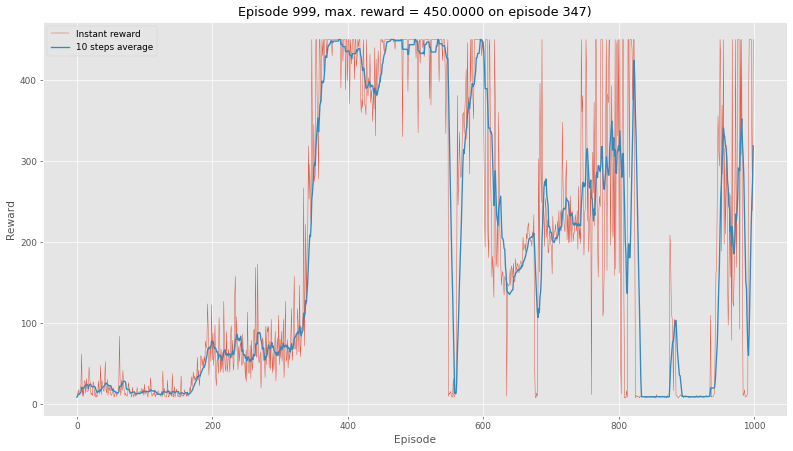

In [9]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title(f'Episode {episode}, max. reward = {max(rewards):5.4f} on episode {np.argmax(rewards)})')
ax.plot(rewards, linewidth=0.5, label='Instant reward')
ax.plot(rewards_avg, linewidth=1.5, label=f'10 steps average')
ax.legend()
plt.plot();

## Evaluación del agente en una instancia del problema

Veamos cómo se comporta el agente en una nueva instancia del problema. En este caso visualizaremos el comportamiento para comprobar si lo resuelve de forma satisfactoria.

In [11]:
env = gymnasium.make('CartPole-v1', render_mode='human')

state, _ = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Seleccionamos una acción dado el actual estado ...
    action = np.argmax(agent.model.predict(state[np.newaxis, ...], verbose=0)[0])
    # ... y la ejecutamos, obteniendo el nuevo estado
    state, _, terminated, truncated, _ = env.step(action)
env.close()

## Conclusiones

Hemos demostrado que implementar un agente para resolver el problema del _Cart Pole_ (el péndulo invertido) es un poco tedioso, pero nada demasiado complicado. Nuestro agente aprendió a equilibrar el péndulo utilizando la información proporcionada por el entorno (esto es, posición y velocidad del carro, inclinación y velocidad angular del péndulo).

Además, también hemos explorado los principales hiperparámetros que afectan a este tipo de algoritmos, como la tasa de aprendizaje, el factor de descuento y el tamaño del _batch_, para optimizar el rendimiento del agente.

En general, el Deep Q Learning es una técnica poderosa y versátil para entrenar agentes de aprendizaje por refuerzo en una amplia gama de problemas.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>